In [ ]:
#Import all the required libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor

In [ ]:
#Read the Dataset

df = pd.read_csv('laptop_price.csv', encoding='latin-1')
df

,laptop_ID,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1316,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,638.00
1299,1317,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,1499.00
1300,1318,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,229.00
1301,1319,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,764.00


In [ ]:
#Print the dataset information

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         1303 non-null   int64  
 1   Company           1303 non-null   object 
 2   Product           1303 non-null   object 
 3   TypeName          1303 non-null   object 
 4   Inches            1303 non-null   float64
 5   ScreenResolution  1303 non-null   object 
 6   Cpu               1303 non-null   object 
 7   Ram               1303 non-null   object 
 8   Memory            1303 non-null   object 
 9   Gpu               1303 non-null   object 
 10  OpSys             1303 non-null   object 
 11  Weight            1303 non-null   object 
 12  Price_euros       1303 non-null   float64
dtypes: float64(2), int64(1), object(10)
memory usage: 132.5+ KB


In [ ]:
#Helper function for plotting the data

def plot_function(title=str, xlabel=str, ylabel=str, label=[], true = [], 
                  predicted = [], vline=0):
    plt.plot(true, '-',)
    if len(predicted) > 0:
      plt.plot(predicted, '-')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    if len(label) > 0:
      plt.legend(label, loc ="upper left")
    if vline:
      plt.axvline(vline, color='r')
    plt.show()

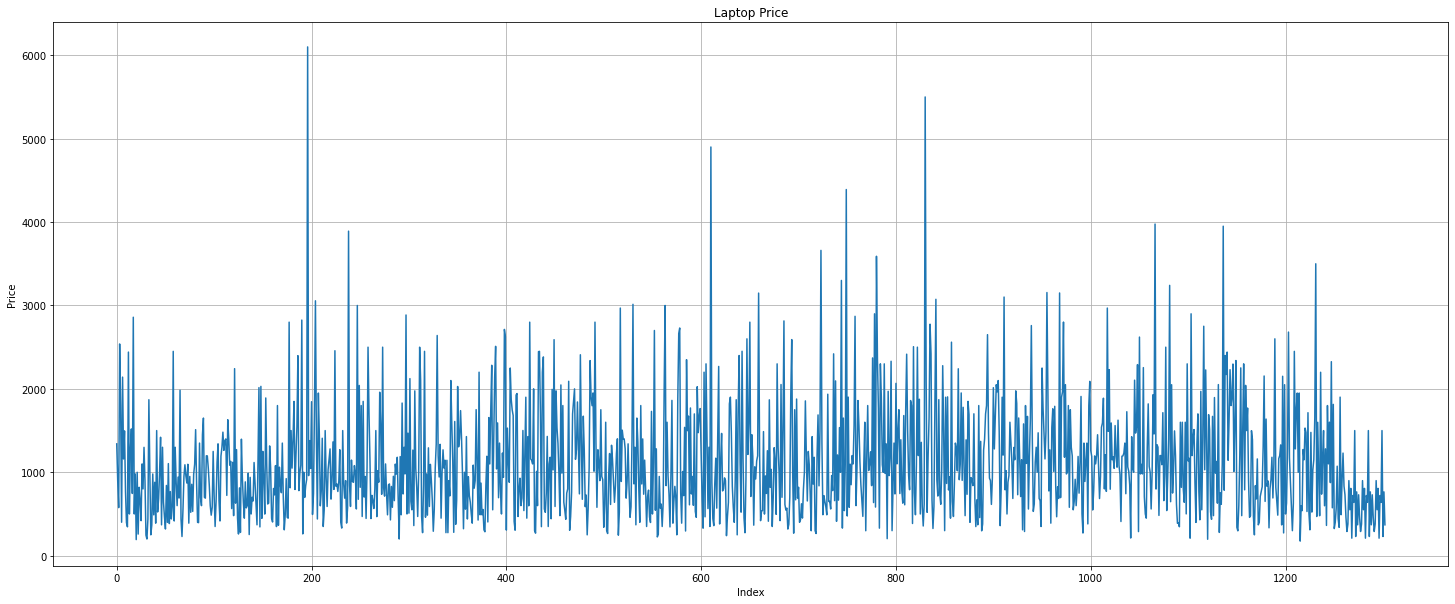

In [ ]:
#Plot the data's prices

title = 'Laptop Price'
x_label = 'Index'
y_label = 'Price'
plt.figure(figsize=(25,10))
plot_function(title=title, xlabel=x_label, ylabel=y_label, 
              true=df['Price_euros'])

In [ ]:
#Check the unique value of each columns

for i in df.columns:
  if i != 'Price_euros':
    print('Column: ', i)
    print('Number unique Value: ', df[i].nunique())
    print('-'*20)

Column:  laptop_ID
Number unique Value:  1303
--------------------
Column:  Company
Number unique Value:  19
--------------------
Column:  Product
Number unique Value:  618
--------------------
Column:  TypeName
Number unique Value:  6
--------------------
Column:  Inches
Number unique Value:  18
--------------------
Column:  ScreenResolution
Number unique Value:  40
--------------------
Column:  Cpu
Number unique Value:  118
--------------------
Column:  Ram
Number unique Value:  9
--------------------
Column:  Memory
Number unique Value:  39
--------------------
Column:  Gpu
Number unique Value:  110
--------------------
Column:  OpSys
Number unique Value:  9
--------------------
Column:  Weight
Number unique Value:  179
--------------------


In [ ]:
#Delete non number in column Weight

df['Weight'] = df['Weight'].str.replace(r"[a-zA-Z]",'')
print(df['Weight'].nunique())

179


In [ ]:
#Delete non number in column Ram

df['Ram'] = df['Ram'].str.replace(r"[a-zA-Z]",'')
print(df['Ram'].nunique())

9


In [ ]:
#Split the laptop that has secondary memory and fill it with 0 if it doesn't has secondary memory
#Drop the laptop_ID column because it's just meaningless number here

df[['Memory', 'Second_memory']] = df['Memory'].str.split('+', n=1, expand=True)
df['Second_memory'] = df['Second_memory'].fillna('0')
df.drop(['laptop_ID'],axis=1, inplace=True)
df

,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros,Second_memory
0,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,0
1,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94,0
2,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00,0
3,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45,0
4,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,14.0,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.8,638.00,0
1299,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.3,1499.00,0
1300,Lenovo,IdeaPad 100S-14IBR,Notebook,14.0,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5,229.00,0
1301,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,764.00,0


In [ ]:
#Rearrange the dataset

end = ['Inches', 'Ram', 'Weight', 'Price_euros']
df = df[[i for i in df if i not in end] 
        + [i for i in end if i in df]]
df

,Company,Product,TypeName,ScreenResolution,Cpu,Memory,Gpu,OpSys,Second_memory,Inches,Ram,Weight,Price_euros
0,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,128GB SSD,Intel Iris Plus Graphics 640,macOS,0,13.3,8,1.37,1339.69
1,Apple,Macbook Air,Ultrabook,1440x900,Intel Core i5 1.8GHz,128GB Flash Storage,Intel HD Graphics 6000,macOS,0,13.3,8,1.34,898.94
2,HP,250 G6,Notebook,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,256GB SSD,Intel HD Graphics 620,No OS,0,15.6,8,1.86,575.00
3,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,512GB SSD,AMD Radeon Pro 455,macOS,0,15.4,16,1.83,2537.45
4,Apple,MacBook Pro,Ultrabook,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,256GB SSD,Intel Iris Plus Graphics 650,macOS,0,13.3,8,1.37,1803.60
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,Yoga 500-14ISK,2 in 1 Convertible,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,128GB SSD,Intel HD Graphics 520,Windows 10,0,14.0,4,1.8,638.00
1299,Lenovo,Yoga 900-13ISK,2 in 1 Convertible,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,512GB SSD,Intel HD Graphics 520,Windows 10,0,13.3,16,1.3,1499.00
1300,Lenovo,IdeaPad 100S-14IBR,Notebook,1366x768,Intel Celeron Dual Core N3050 1.6GHz,64GB Flash Storage,Intel HD Graphics,Windows 10,0,14.0,2,1.5,229.00
1301,HP,15-AC110nv (i7-6500U/6GB/1TB/Radeon,Notebook,1366x768,Intel Core i7 6500U 2.5GHz,1TB HDD,AMD Radeon R5 M330,Windows 10,0,15.6,6,2.19,764.00


In [ ]:
#Encode and scaled the dataset

oe = OrdinalEncoder(dtype=np.int)
scaler = MinMaxScaler()

df_encoded = np.array(oe.fit_transform(df[['Company', 'Product', 'TypeName', 
                                         'ScreenResolution', 'Cpu', 'Memory', 'Gpu', 
                                         'OpSys', 'Second_memory']].values))
y_normalize = np.array(scaler.fit_transform(df[['Price_euros']].values))
print(df_encoded)
print(y_normalize)

[[  1 300   4 ...  58   8   6]
 [  1 301   4 ...  51   8   6]
 [  7  50   3 ...  53   4   6]
 ...
 [ 10 196   3 ...  40   5   6]
 [  7   2   3 ...  21   5   6]
 [  2 568   3 ...  40   5   6]]
[[0.19674093]
 [0.12235274]
 [0.06767932]
 ...
 [0.0092827 ]
 [0.09957806]
 [0.03291139]]


In [ ]:
#Construct the dataset again

for i in df.columns:
  if i in end:
    if i != 'Price_euros':
      df_encoded = np.hstack([df_encoded, df[i].to_numpy().reshape(-1,1)])
df_encoded = np.hstack([df_encoded, y_normalize.reshape(-1,1)])
df_encoded

array([[1.0, 300.0, 4.0, ..., '8', '1.37', 0.1967409282700422],
       [1.0, 301.0, 4.0, ..., '8', '1.34', 0.12235274261603377],
       [7.0, 50.0, 3.0, ..., '8', '1.86', 0.06767932489451477],
       ...,
       [10.0, 196.0, 3.0, ..., '2', '1.5', 0.009282700421940928],
       [7.0, 2.0, 3.0, ..., '6', '2.19', 0.09957805907172995],
       [2.0, 568.0, 3.0, ..., '4', '2.2', 0.032911392405063286]],
      dtype=object)

In [ ]:
#Make a dataframe from encoded and scaled dataset

df_encoded = pd.DataFrame(df_encoded, columns=df.columns, dtype=float)
df_encoded

,Company,Product,TypeName,ScreenResolution,Cpu,Memory,Gpu,OpSys,Second_memory,Inches,Ram,Weight,Price_euros
0,1.0,300.0,4.0,23.0,65.0,4.0,58.0,8.0,6.0,13.3,8.0,1.37,0.196741
1,1.0,301.0,4.0,1.0,63.0,2.0,51.0,8.0,6.0,13.3,8.0,1.34,0.122353
2,7.0,50.0,3.0,8.0,74.0,15.0,53.0,4.0,6.0,15.6,8.0,1.86,0.067679
3,1.0,300.0,4.0,25.0,85.0,24.0,9.0,8.0,6.0,15.4,16.0,1.83,0.398895
4,1.0,300.0,4.0,23.0,67.0,15.0,59.0,8.0,6.0,13.3,8.0,1.37,0.275038
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,10.0,580.0,0.0,13.0,89.0,4.0,47.0,5.0,6.0,14.0,4.0,1.80,0.078312
1299,10.0,588.0,0.0,19.0,89.0,24.0,47.0,5.0,6.0,13.3,16.0,1.30,0.223629
1300,10.0,196.0,3.0,0.0,34.0,26.0,40.0,5.0,6.0,14.0,2.0,1.50,0.009283
1301,7.0,2.0,3.0,0.0,89.0,9.0,21.0,5.0,6.0,15.6,6.0,2.19,0.099578


In [ ]:
#Check the dataset information again

df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303 entries, 0 to 1302
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Company           1303 non-null   float64
 1   Product           1303 non-null   float64
 2   TypeName          1303 non-null   float64
 3   ScreenResolution  1303 non-null   float64
 4   Cpu               1303 non-null   float64
 5   Memory            1303 non-null   float64
 6   Gpu               1303 non-null   float64
 7   OpSys             1303 non-null   float64
 8   Second_memory     1303 non-null   float64
 9   Inches            1303 non-null   float64
 10  Ram               1303 non-null   float64
 11  Weight            1303 non-null   float64
 12  Price_euros       1303 non-null   float64
dtypes: float64(13)
memory usage: 132.5 KB


In [ ]:
#Check the description of the dataset

df_encoded.describe().T

,count,mean,std,min,25%,50%,75%,max
Company,1303.0,6.442824,4.084128,0.00,4.00000,7.000000,10.000000,18.0
Product,1303.0,308.207214,171.887833,0.00,182.50000,291.000000,455.500000,617.0
TypeName,1303.0,2.582502,1.245231,0.00,1.50000,3.000000,3.000000,5.0
ScreenResolution,1303.0,9.224098,7.885050,0.00,6.00000,8.000000,15.000000,39.0
Cpu,1303.0,76.983883,25.190467,0.00,65.00000,78.000000,97.000000,117.0
Memory,1303.0,14.240982,6.174394,0.00,9.00000,15.000000,18.000000,29.0
Gpu,1303.0,54.682272,21.623195,0.00,46.00000,53.000000,72.000000,109.0
OpSys,1303.0,4.808903,1.035253,0.00,5.00000,5.000000,5.000000,8.0
Second_memory,1303.0,5.233308,1.779529,0.00,6.00000,6.000000,6.000000,6.0
Inches,1303.0,15.017191,1.426304,10.10,14.00000,15.600000,15.600000,18.4


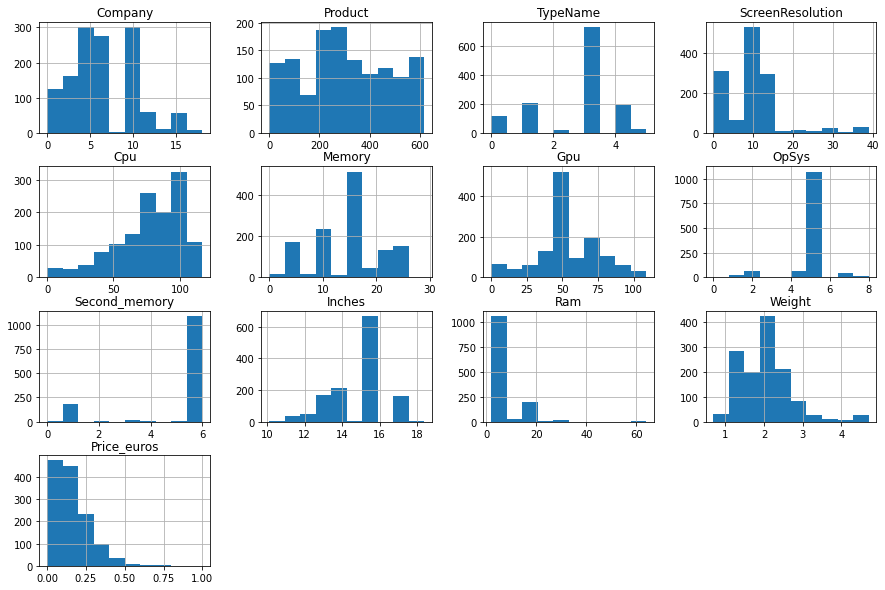

In [ ]:
#Check the histogram of the dataset

_ = df_encoded.hist(figsize=(15,10))

In [ ]:
#Prepare the data

X = df_encoded.drop(['Price_euros'], axis=1)
X

,Company,Product,TypeName,ScreenResolution,Cpu,Memory,Gpu,OpSys,Second_memory,Inches,Ram,Weight
0,1.0,300.0,4.0,23.0,65.0,4.0,58.0,8.0,6.0,13.3,8.0,1.37
1,1.0,301.0,4.0,1.0,63.0,2.0,51.0,8.0,6.0,13.3,8.0,1.34
2,7.0,50.0,3.0,8.0,74.0,15.0,53.0,4.0,6.0,15.6,8.0,1.86
3,1.0,300.0,4.0,25.0,85.0,24.0,9.0,8.0,6.0,15.4,16.0,1.83
4,1.0,300.0,4.0,23.0,67.0,15.0,59.0,8.0,6.0,13.3,8.0,1.37
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,10.0,580.0,0.0,13.0,89.0,4.0,47.0,5.0,6.0,14.0,4.0,1.80
1299,10.0,588.0,0.0,19.0,89.0,24.0,47.0,5.0,6.0,13.3,16.0,1.30
1300,10.0,196.0,3.0,0.0,34.0,26.0,40.0,5.0,6.0,14.0,2.0,1.50
1301,7.0,2.0,3.0,0.0,89.0,9.0,21.0,5.0,6.0,15.6,6.0,2.19


In [ ]:
#Prepare the target

y = df_encoded['Price_euros']
y

0       0.196741
1       0.122353
2       0.067679
3       0.398895
4       0.275038
          ...   
1298    0.078312
1299    0.223629
1300    0.009283
1301    0.099578
1302    0.032911
Name: Price_euros, Length: 1303, dtype: float64

In [ ]:
#Helper function for splitting the data

def split_train_test(X = [], y = [], train_size = float):
  X_train = np.array(X[:train_size])
  y_train = np.array(y[:train_size])
  X_test = np.array(X[train_size:])
  y_test = np.array(y[train_size:])
  return (X_train, X_test, y_train, y_test)

In [ ]:
#Splitting data into 80% of train and 20% of test

train_size = int(X.shape[0] * 0.8)
X_train, X_test, y_train, y_test = split_train_test(X, y, train_size)

In [ ]:
#Fit the XGBoost Model with dataset

model = XGBRegressor(n_estimators=1250, random_state=23,
                     objective='reg:squarederror', n_jobs=-1)
model.fit(X_train, y_train)
X_train_predicted = model.predict(X_train)
print('MSE score for train data is: ', mean_squared_error(y_train, 
                                                          X_train_predicted))

MSE score for train data is:  0.00010650141909813345


In [ ]:
#Print the MSE score of the test data

y_predicted = model.predict(X_test)
print('MSE score for test data is: ', mean_squared_error(y_test, 
                                                          y_predicted))

MSE score for test data is:  0.002709144309397954


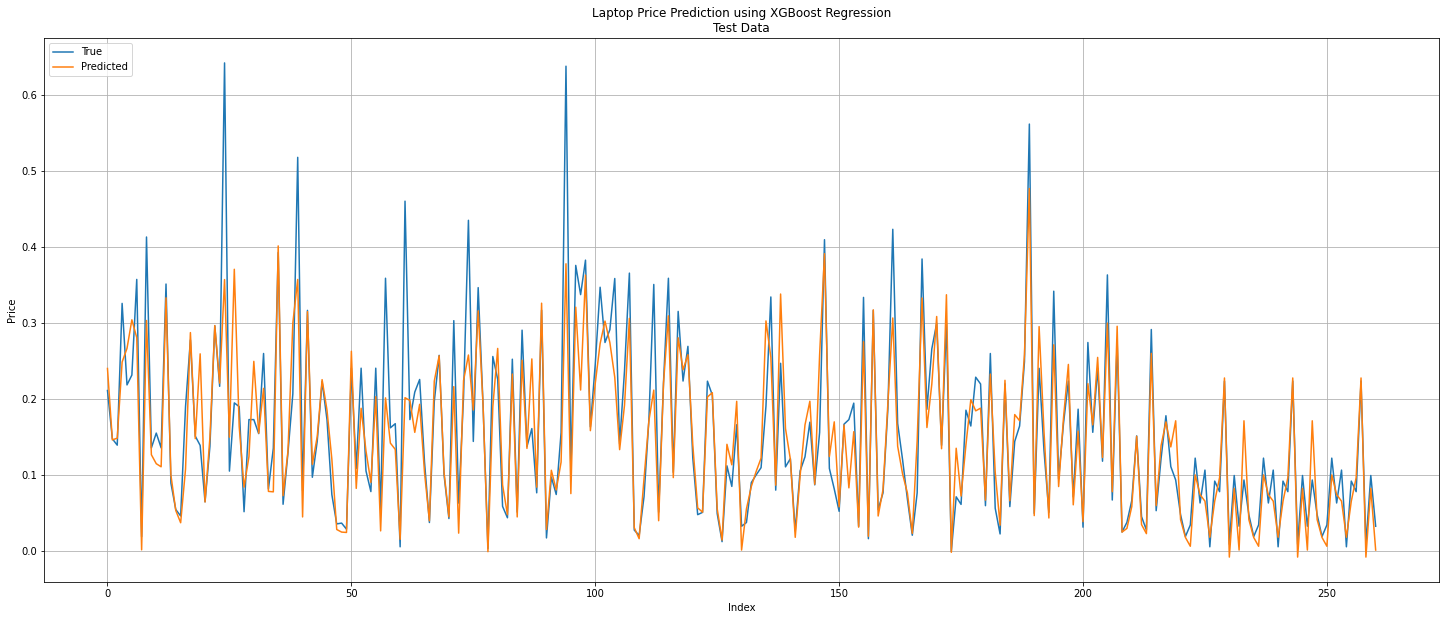

In [ ]:
#Plot the true and predicted test data

title = 'Laptop Price Prediction using XGBoost Regression\nTest Data'
x_label = 'Index'
y_label = 'Price'
label = ['True', 'Predicted']
plt.figure(figsize=(25,10))
plot_function(title=title, xlabel=x_label, ylabel=y_label, label=label, 
              true=y_test, predicted=y_predicted)

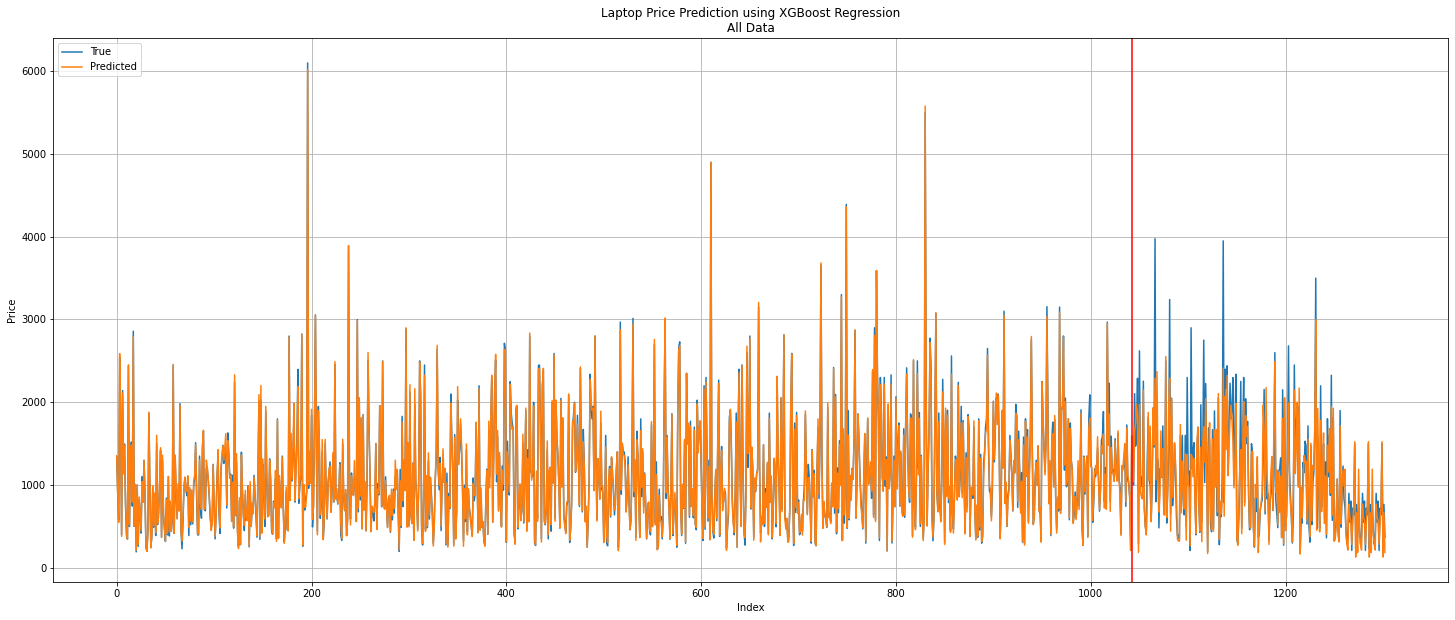

In [ ]:
#Plot the true and predicted all data

data_predicted = model.predict(X.to_numpy())
data_predicted_denormalized = scaler.inverse_transform(data_predicted.reshape(-1,1))
title = 'Laptop Price Prediction using XGBoost Regression\nAll Data'
x_label = 'Index'
y_label = 'Price'
label = ['True', 'Predicted']
plt.figure(figsize=(25,10))
plot_function(title=title, xlabel=x_label, ylabel=y_label, label=label, 
              true=df['Price_euros'], predicted=data_predicted_denormalized, vline=train_size)